In [5]:
!pip install -q tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 21kB/s 
     |████████████████████████████████| 450kB 39.5MB/s 
     |████████████████████████████████| 3.9MB 39.6MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [6]:
!pip install -q tensorflow-quantum

     |████████████████████████████████| 3.9MB 26kB/s 
     |████████████████████████████████| 163kB 7.9MB/s 
     |████████████████████████████████| 1.4MB 29.1MB/s 
     |████████████████████████████████| 5.3MB 28.6MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 112kB 39.6MB/s 
     |████████████████████████████████| 1.2MB 41.0MB/s 


In [7]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
'''
q = cirq.GridQubit(0, 0)
a = sympy.symbols('a')
circuit = cirq.Circuit(
    cirq.ry(a)(q)
)

outputs = tfq.layers.PQC(circuit, cirq.Z(q))
quantum_data = tfq.convert_to_tensor([cirq.Circuit()])
outputs(quantum_data)
'''

"\nq = cirq.GridQubit(0, 0)\na = sympy.symbols('a')\ncircuit = cirq.Circuit(\n    cirq.ry(a)(q)\n)\n\noutputs = tfq.layers.PQC(circuit, cirq.Z(q))\nquantum_data = tfq.convert_to_tensor([cirq.Circuit()])\noutputs(quantum_data)\n"

In [80]:
x_train=2*np.random.rand(800,1,1,1)-1
x_test=2*np.random.rand(200,1,1,1)-1

#y_train=-np.abs(np.reshape(x_train,(-1,1)))+0.5
#y_test=-np.abs(np.reshape(x_test,(-1,1)))+0.5
#y_train=4*(np.abs(np.abs(np.reshape(x_train,(-1,1)))-0.5)-0.25)
#y_test=4*(np.abs(np.abs(np.reshape(x_test,(-1,1)))-0.5)-0.25)
y_train=np.cos(x_train*np.pi)
y_test=np.cos(x_test*np.pi)

np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test)

((8000, 1, 1, 1), (2000, 1, 1, 1), (8000, 1, 1, 1), (2000, 1, 1, 1))

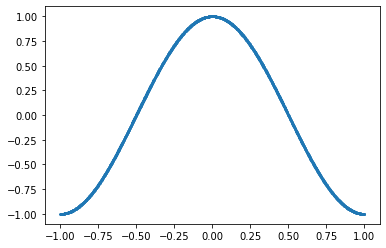

In [81]:
plt.scatter(np.reshape(x_train,-1),y_train,s=1)

In [0]:
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(1,1)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        circuit.append(cirq.ry(np.pi*value).on(qubits[i]))
        #if value: circuit.append(cirq.X(qubits[i]))
    return circuit

x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

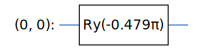

In [83]:
SVGCircuit(x_train_circ[0])

In [0]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [0]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])
    
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [0]:
def create_quantum_model():
    qubits = cirq.GridQubit.rect(1,2) 
    circuit = cirq.Circuit()
    circuit+=two_qubit_unitary(qubits, sympy.symbols('x0:15'))
    circuit+=two_qubit_pool(*qubits, sympy.symbols('y0:6'))

    return circuit, cirq.Z(qubits[1])

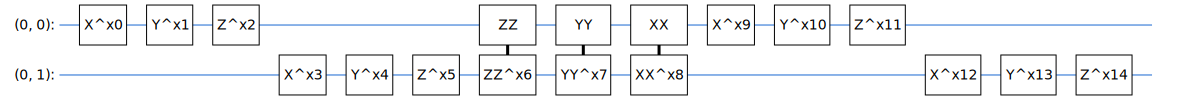

In [87]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

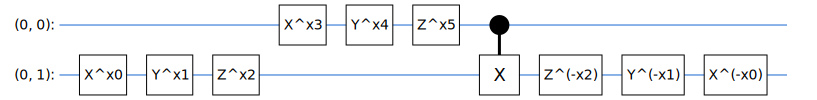

In [88]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

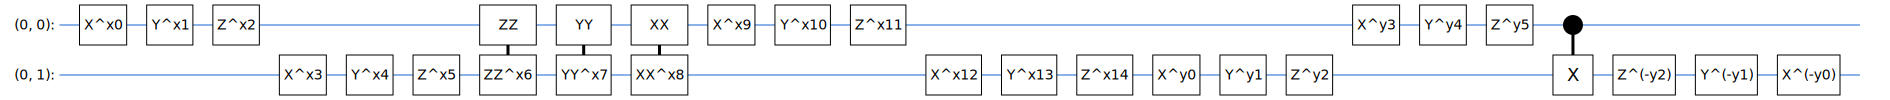

In [89]:
circuit,readout = create_quantum_model()
SVGCircuit(circuit)

In [0]:
model_circuit, model_readout = create_quantum_model()

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout)
])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_4 (PQC)                  (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
None


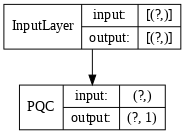

In [92]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam())

print(model.summary())

tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False,dpi=70)

In [0]:
EPOCHS = 5
BATCH_SIZE = 128

In [94]:
qnn_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 35s 4ms/sample - loss: 0.5059 - val_loss: 0.4993
Epoch 2/5
8000/8000 [==============================] - 35s 4ms/sample - loss: 0.4977 - val_loss: 0.4995
Epoch 3/5
8000/8000 [==============================] - 35s 4ms/sample - loss: 0.4976 - val_loss: 0.4988
Epoch 4/5
8000/8000 [==============================] - 35s 4ms/sample - loss: 0.4978 - val_loss: 0.4998
Epoch 5/5
2000/2000 [==============================] - 1s 509us/sample - loss: 0.4993


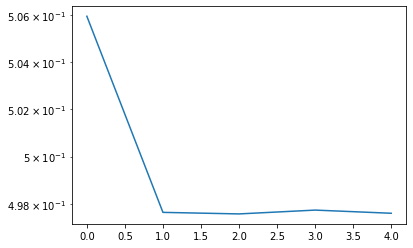

In [95]:
plt.semilogy(qnn_history.history['loss'])

In [0]:
y_pred=model.predict(x_train_tfcirc)

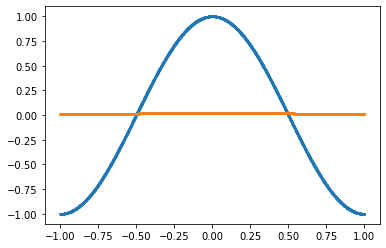

In [97]:
plt.scatter(np.reshape(x_train,-1),y_train,s=1)
plt.scatter(np.reshape(x_train,-1),y_pred,s=1)

In [98]:
model.weights

[<tf.Variable 'parameters:0' shape=(21,) dtype=float32, numpy=
 array([2.832447  , 0.5373346 , 6.215775  , 0.06523573, 4.894816  ,
        2.4421835 , 0.22907455, 1.6016374 , 4.2321568 , 5.9252367 ,
        3.0096798 , 4.363609  , 3.9258213 , 4.5905476 , 0.9070683 ,
        1.5895116 , 3.5328948 , 5.8844385 , 0.66480064, 5.6294675 ,
        0.21206078], dtype=float32)>]